In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
mpl.use("Cairo")  # for saving SVGs that Affinity Designer can parse

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

import pathlib as pl
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

In [3]:
width = 7.08
height = 0.7
figsize = (width, height)
ticklabelsize = 6
labelsize = 6
titlesize = labelsize

# Set rcParams for plotting
mpl.rc("xtick", labelsize=ticklabelsize)
mpl.rc("ytick", labelsize=ticklabelsize)
mpl.rc("axes", labelsize=labelsize, titlesize=titlesize, linewidth=0.5)

mar_t = 0.5
mar_b = 2.5
mar_r=0.1775
mar_l=0.075
wspace=0.3


def format_fig(
    fig, figsize=figsize, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, mar_b=mar_b, **kwargs
):
    """Adjust margins of subplots using figsize"""
    height, width = figsize
    fig.set_size_inches(figsize)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        **kwargs
    )

    for ax in fig.get_axes():
        ax.tick_params(which="both", length=1.0, width=0.5)

In [4]:
cmax = 50

JG075B = (
    QuantStudio(
        data_pth / "JG075B L-MMMMx blocker tripartite competition separate.xlsx",
        "JG075B",
    )
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore("FAM")
)

# Denote reaction conditions
JG075B.reactions.wide = (
    JG075B.reactions.wide.replace(
        {
            "Target": {
                "S075_WTFAM": "S075_WT",
                "S075_WTHEX": "S075_WT",
                "S075_SNVFAM": "S075_SNV",
                "S075_SNVHEX": "S075_SNV",
            }
        }
    )
    .merge(
        pd.read_csv(data_pth / "JG075B Plate Map.csv")
    )  # [['Sample','WT Conc','Competitor Conc','Primer Conc']])
    .assign(lg10_Blocker=lambda df: np.log10(df["Blocker μM"]))
    .replace({"lg10_Blocker": {-np.inf: -2}})
    .drop(columns=["CT"])
)


JG075B.reactions.neaten()
JG075B.extract_endpoints(cmax=cmax)
endpoints = JG075B.endpoints
JG075B.reactions

/home/john/mambaforge/envs/can_manuscript/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Sample,Task,Comments,Reaction,Blocker,Blocker μM,Configuration,WellName,lg10_Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,1,-0.001097,0.003485
1,JG075B,1,S075_WT,8.0,False,A1,100000000.0,HEX,JG075B_001,STANDARD,,1,L-MMMMx,3.162278,2+2,A1,0.5,1,0.000695,0.001712
2,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,2,-0.000667,0.002776
3,JG075B,1,S075_WT,8.0,False,A1,100000000.0,HEX,JG075B_001,STANDARD,,1,L-MMMMx,3.162278,2+2,A1,0.5,2,0.000553,0.001408
4,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,3,0.002053,0.000296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,88,1.717209,1.278983
44636,JG075B,376,S075_SNV,1.0,False,P16,10.0,FAM,JG075B_376,STANDARD,,494,L-MMMMx,0.000000,7+2,P16,-2.0,89,-0.453918,0.440494
44637,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,89,1.735487,1.292101
44638,JG075B,376,S075_SNV,1.0,False,P16,10.0,FAM,JG075B_376,STANDARD,,494,L-MMMMx,0.000000,7+2,P16,-2.0,90,-0.458040,0.444762


In [5]:
target_palette = list(zip(["S075_WT", "S075_SNV"], ["Purples", "Greens"]))

In [6]:
ds = gmb.DataSet(JG075B.endpoints, outputs=["SignalDifference"])
gp = gmb.GP(ds).fit(
    continuous_dims=["lg10_Copies", "Blocker μM"],
    categorical_dims=["Configuration", "Target"],
)

Saving fig_ED1E__strong_xerus in /home/john/projects/can-manuscript/fig_ED1__shy_quokka/graphics: [.svg] [.png] done


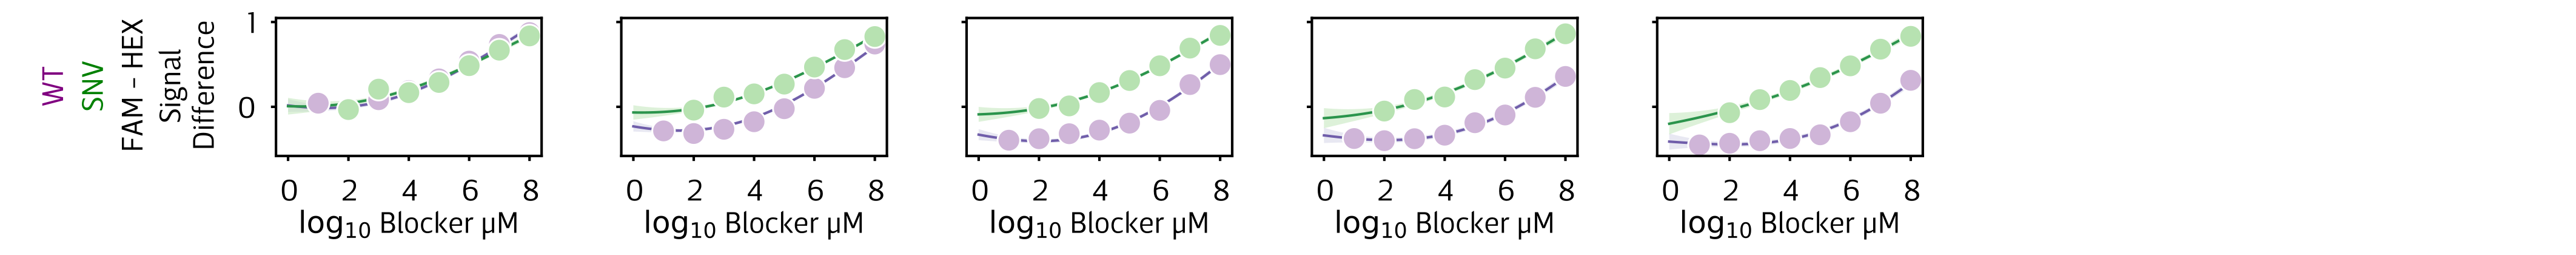

In [7]:
hue = "SignalDifference"
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)
config = "2+2"


with np.errstate(divide='ignore'):
    data = endpoints[
        (endpoints.Configuration == config) & 
        (np.log10(endpoints["Blocker μM"]) % 0.5).isin([0., np.nan])  # Half-log intervals
    ]

g = sns.relplot(
    data=data,
    x="lg10_Copies",
    y="SignalDifference",
    col="Blocker μM",  # row='Configuration',
    hue="Target",
    legend=False,
    palette="PRGn",
    kind="scatter",
    height=2,
    aspect=1.5,
    s=20,
    facet_kws={"margin_titles": True, "despine": False},
)

# g.refline(y=0, color='k', linestyle=':', zorder=-11, linewidth=0.5)
g.set_titles(col_template="", row_template="")
g.set(xticks=[0, 2, 4, 6, 8])

for (col_val), ax in g.axes_dict.items():
    at = gp.parray(**{"Blocker μM": col_val})
    limits = gp.parray(lg10_Copies=[0, 8])
    X = gp.prepare_grid(at=at, limits=limits)["lg10_Copies"]
    WT_sig = gp.predict_grid(
        categorical_levels={"Target": "S075_WT", "Configuration": "2+2"},
        with_noise=False,
    )
    SNV_sig = gp.predict_grid(
        categorical_levels={"Target": "S075_SNV", "Configuration": "2+2"},
        with_noise=False,
    )

    plt.sca(ax)
    gmb.ParrayPlotter(x=X, y=WT_sig).plot(palette="Purples", line_kws={'lw': 0.5})
    gmb.ParrayPlotter(x=X, y=SNV_sig).plot(palette="Greens", line_kws={'lw': 0.5})
    
    ax.set_ylabel('')

fig = plt.gcf()
ax = fig.axes[0]

txt_kws = dict(
    y=0.5,
    fontsize=labelsize,
    transform=ax.transAxes,
    ha="right",
    va="center",
    rotation=90,)

g.set_xlabels(r"$log_{10}$"+" Blocker μM", fontsize=labelsize, labelpad=0.5)

ax.text(
    x=-0.325,
    s='Signal\nDifference',
    color = "k",
    **(txt_kws | {'ha': 'center'})
)

ax.text(
    x=-0.475,
    s='FAM - HEX',
    color = "k",
    **txt_kws
)

ax.text(
    x=-0.625,
    s='SNV',
    color = "green",
    **txt_kws
)

ax.text(
    x=-0.775,
    s='WT',
    color = "purple",
    **txt_kws
)

format_fig(
    fig,
    figsize=(width, height),
    mar_t=0.5,
    mar_b=2.75,
    wspace=wspace
)

savefig(fig, alias="strong_xerus")